# Overview:

This notebook focuses on analyzing a Nathan lab dataset derived from a genome-wide CRISPRi screen of Mycobacterium tuberculosis.

The raw input data has been processed (by M. deJesus et al.) using Mageck.

The overarching goal of this analysis is to identify key genes that play significant roles in different stages or conditions of the infection process, as simulated in the CRISPRi screens.



# Import libraries:


In [1]:
import os
import pandas as pd
from tqdm import tqdm
import numpy as np

import umap

import hvplot.pandas
import holoviews as hv
import bokeh.io
import bokeh.plotting
bokeh.io.output_notebook()

import matplotlib.pyplot as plt
import seaborn as sns

/home/ajinich/miniconda3/envs/mtb_repo_env/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Loading BokehJS ...

# Paths to input data files:


In [2]:
path_root = "/content/drive/MyDrive/TheJinichLab/collaborations/Carl_Nathan/"
path_data = os.path.join(path_root, 'Stagewise_Mageck')
fn_meta = os.path.join(path_root, 'Stagewise_Mageck.xlsx')

### Metadata files:
This loads the file that maps each experimental condtion to a single concise code or identifier.

The mapping is stored as a python dictionary.

In [3]:
df_meta = pd.read_excel(fn_meta)
col_fn = 'Comparison file name'
col_short = 'Code'
dict_fn_to_id = dict(zip(df_meta[col_fn], df_meta[col_short]))

# Preprocessing Data Files Section Overview:
This section is dedicated to preprocessing and organizing the data from numerous spreadsheets, each corresponding to different CRISPRi screens or experimental conditions. The aim is to consolidate all relevant data into two master DataFrames:

1. df_master_logFC: Captures the log2 fold changes (LFC) for each gene across various experimental conditions.
2. df_master_pval: Contains the FDR-corrected p-values for each gene, indicative of the statistical significance of the changes observed in the CRISPRi screens.

### NOTE: In the current implementation, we focus on only obtain "neg|lfc" and "neg|fdr" values, corresponding to CRISPRi knockdown depletions.  
### NOTE: The column name in each dataframe corresponds to the concise codes/identifiers obtained from the metadata file above.



In [4]:
def process_file(fn_path, col_lfc, col_pval, col_gene):
    df_temp = pd.read_csv(fn_path, sep='\t')

    df_temp = df_temp[[col_gene, col_lfc, col_pval]]
    return df_temp

In [5]:
col_lfc = 'neg|lfc'
col_pval = 'neg|fdr'
col_gene = 'id'

# Initialize master dataframes
df_master_logFC = pd.DataFrame()
df_master_pval = pd.DataFrame()

# Loop through directories, subdirectories, and files
for dirpath, dirnames, filenames in os.walk(path_data):
    for filename in tqdm(filenames, desc="Processing files"):
        # Construct the full path to the file
        full_file_path = os.path.join(dirpath, filename)
        file_id = dict_fn_to_id[filename.split('.txt')[0]]
        df = process_file(full_file_path, col_lfc, col_pval, col_gene)
        # Rename the columns before merging
        df = df.rename(columns={col_lfc: 'lfc_'+file_id, col_pval: 'pval_'+file_id})
        # Merge the dataframes
        if df_master_logFC.empty:
            df_master_logFC = df[[col_gene, 'lfc_'+file_id]].copy()
        else:
            df_master_logFC = df_master_logFC.merge(df[[col_gene, 'lfc_'+file_id]], on=col_gene, how='outer')

        if df_master_pval.empty:
            df_master_pval = df[[col_gene, 'pval_'+file_id]].copy()
        else:
            df_master_pval = df_master_pval.merge(df[[col_gene, 'pval_'+file_id]], on=col_gene, how='outer')

Processing files: 0it [00:00, ?it/s]
Processing files: 100%|██████████| 12/12 [00:04<00:00,  2.83it/s]


In [6]:
df_master_logFC.head(2)

,id,lfc_M.II.5G.10%O2vsDep.Yes,lfc_M.III.20G.10%O20.2%O2.Yes,lfc_M.III.5G.10%O2vsDep.No,lfc_M.III.20G.10%O20.2%O2.No,lfc_M.III.10G.10%O2vsDep.No,lfc_M.III.20G.10%O2vsDep.No,lfc_M.III.5G.10%O20.2%O2.No,lfc_M.III.5G.10%O2vsDep.Yes,lfc_M.II.10G.10%O2vsDep.Yes,...,lfc_M.III.20G.P18hrsvsDep.Yes,lfc_M.III.5G.P18hrsvsDep.Yes,lfc_M.III.10G.P18hrsvsDep.No,lfc_M.III.5G.P18hrsD1d.Yes,lfc_M.III.20G.P18hrsD1d.No,lfc_M.III.20G.P18hrsvsDep.No,lfc_M.III.5G.P18hrsD1d.No,lfc_M.III.10G.P18hrsvsDep.Yes,lfc_M.III.5G.P18hrsvsDep.No,lfc_M.III.20G.P18hrsD1d.Yes
0,RVBD3859c:gltB,-2.2731,-0.67655,-0.84015,-1.07710,-0.94891,-0.76914,-0.69240,-1.7030,-1.2670,...,-1.1726,-2.1910,-1.3182,-1.4032,-0.95102,-1.0272,-0.88312,-1.1289,-0.88955,-1.3317
1,RVBD3596c:clpC1,-3.7115,-0.83038,-1.36260,-0.72416,-1.39180,-0.97576,-0.63026,-5.4972,-1.7801,...,-1.2945,-2.7884,-1.8598,-1.9312,-0.92135,-1.3439,-1.05230,-1.6890,-1.97740,-5.0361


In [7]:
df_master_pval.head(2)


,id,pval_M.II.5G.10%O2vsDep.Yes,pval_M.III.20G.10%O20.2%O2.Yes,pval_M.III.5G.10%O2vsDep.No,pval_M.III.20G.10%O20.2%O2.No,pval_M.III.10G.10%O2vsDep.No,pval_M.III.20G.10%O2vsDep.No,pval_M.III.5G.10%O20.2%O2.No,pval_M.III.5G.10%O2vsDep.Yes,pval_M.II.10G.10%O2vsDep.Yes,...,pval_M.III.20G.P18hrsvsDep.Yes,pval_M.III.5G.P18hrsvsDep.Yes,pval_M.III.10G.P18hrsvsDep.No,pval_M.III.5G.P18hrsD1d.Yes,pval_M.III.20G.P18hrsD1d.No,pval_M.III.20G.P18hrsvsDep.No,pval_M.III.5G.P18hrsD1d.No,pval_M.III.10G.P18hrsvsDep.Yes,pval_M.III.5G.P18hrsvsDep.No,pval_M.III.20G.P18hrsD1d.Yes
0,RVBD3859c:gltB,0.000003,1.0,0.700511,0.000074,0.000033,0.000057,1.0,1.0,0.000004,...,1.0,1.000000,0.000022,0.196100,0.047366,0.008045,0.097819,0.000014,1.00000,1.0
1,RVBD3596c:clpC1,0.000003,1.0,0.000059,0.112821,0.000033,0.010879,1.0,1.0,0.000004,...,1.0,0.000118,0.000022,0.005712,0.005472,0.000099,0.002260,0.000014,0.00004,1.0


# Analysis of Missing Values (NaNs) Across Experimental Conditions:

This section is focused on identifying experimental conditions (columns in the master dataframes) that have a significant number of missing values (NaNs).

The goal is to visually and quantitatively assess which experiments are characterized by substantial data gaps, which could impact the reliability and interpretability of subsequent analyses.

### Heatmap Visualization:
- A heatmap is created to visually represent the presence of NaNs across different conditions.
- In this heatmap, each column corresponds to an experimental condition, while each row represents a gene.
- The presence of NaNs is indicated by the color coding (typically yellow in the 'viridis' color map), making it easy to spot columns with high NaN counts.


In [8]:
nan_counts = df_master_logFC.isna().sum()
sorted_nan_counts = nan_counts.sort_values(ascending=False)
sorted_nan_counts.to_excel(os.path.join(path_root, 'sorted_nan_counts.xlsx'))

<Axes: >

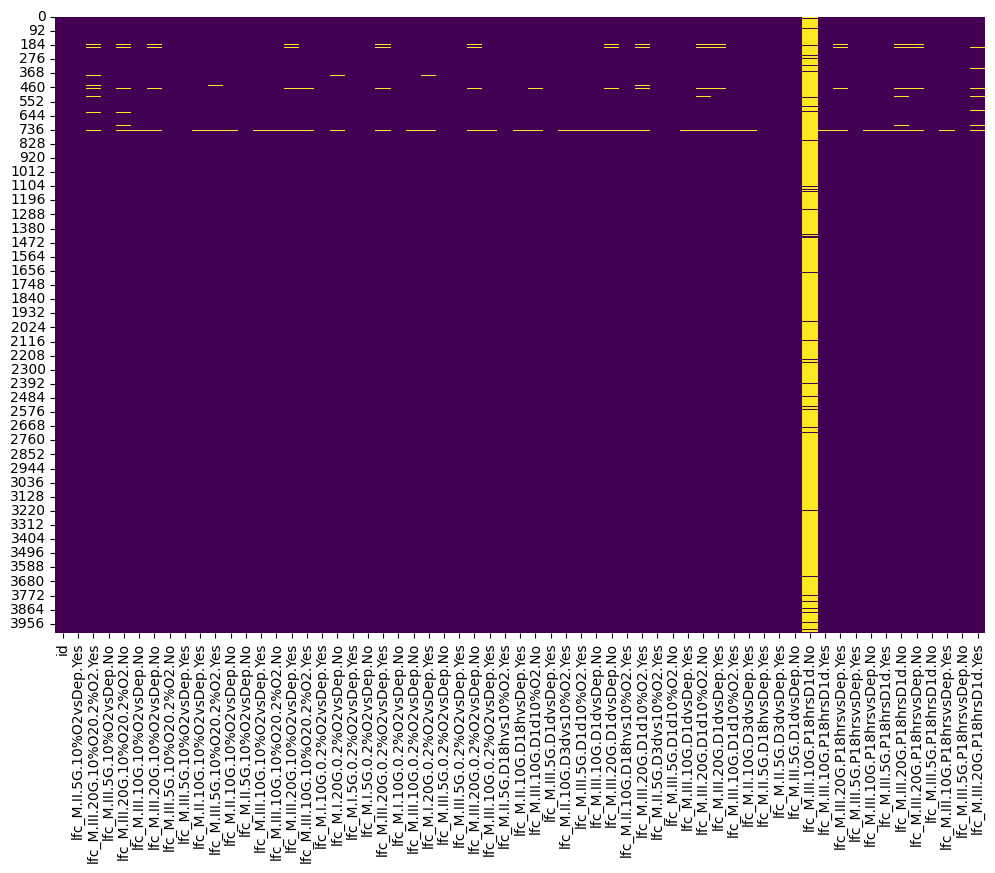

In [9]:
plt.figure(figsize=(12, 8))
sns.heatmap(df_master_logFC.isna(), cbar=False, cmap='viridis')

#### Which is the condition with a very large number of missing values?


In [10]:
search_value = 'M.III.10G.P18hrsD1d.No'
key = next((k for k, v in dict_fn_to_id.items() if v == search_value), None)
key


'result_6161_10Generation_PostMALFwithATc_vs_6155_10Generation_PostDesiccationwithATc_alphamedian_control_control_ctrl_2_lod20_11_03_2023.mageck.gene_summary'

#### What are the "top ten" screens in terms of missing values?

In [11]:
sorted_nan_counts.head(10)

lfc_M.III.10G.P18hrsD1d.No       3727
lfc_M.III.20G.10%O20.2%O2.Yes      49
lfc_M.III.20G.P18hrsD1d.Yes        43
lfc_M.III.20G.D1d10%O2.Yes         34
lfc_M.III.20G.D1d10%O2.No          31
lfc_M.III.20G.P18hrsvsDep.No       29
lfc_M.III.20G.10%O20.2%O2.No       29
lfc_M.III.20G.0.2%O2vsDep.Yes      29
lfc_M.III.20G.D1dvsDep.Yes         29
lfc_M.III.20G.P18hrsD1d.No         28
dtype: int64

Discard top screen with the most missing values:

In [12]:
# Checking the size of the dataframes before dropping the columns
size_before_logFC = df_master_logFC.shape
size_before_pval = df_master_pval.shape

# Dropping the specified columns
df_master_logFC = df_master_logFC.drop(columns=['lfc_M.III.10G.P18hrsD1d.No'])
df_master_pval = df_master_pval.drop(columns=['pval_M.III.10G.P18hrsD1d.No'])

# Checking the size of the dataframes after dropping the columns
size_after_logFC = df_master_logFC.shape
size_after_pval = df_master_pval.shape

size_before_logFC, size_before_pval, size_after_logFC, size_after_pval


((4015, 61), (4015, 61), (4015, 60), (4015, 60))

# Descriptive Statistics Section Overview:

This section aims to provide a descriptive statistical analysis of the log2 fold change (LFC) values across various CRISPRi screens represented in the df_master_logFC DataFrame.

The focus is on understanding the distribution and variability of LFC values, which may help in interpreting the data accurately and identifying trends or outliers.

- **Computing Basic Statistics**: The describe() method is applied to df_master_logFC to compute essential statistics like count, mean, standard deviation, minimum, and maximum for each screen (column).
- **Adding Variance**: Variance is calculated for each screen using the var() method, providing insight into the spread of LFC values.
- **Sorting and Displaying Variance**: The statistics DataFrame is sorted by variance in descending order to highlight screens with the highest variability in gene expression changes.
- **Visualization with Boxplot**: The DataFrame is melted into long-form (melted_df) suitable for seaborn's boxplot function, with 'id' as the identifier, 'screen' as the variable, and 'log2FC' as the value.




In [13]:
stats_df = df_master_logFC.describe().T  # Transpose to get statistics for each screen
stats_df['variance'] = df_master_logFC.var(numeric_only=True)  # Adding variance to the statistics

# Display the statistics dataframe
sorted_stats_df = stats_df.sort_values(by='variance', ascending=False)
sorted_stats_df[['count', 'variance']].head()

,count,variance
lfc_M.III.5G.10%O20.2%O2.Yes,4009.0,2.445809
lfc_M.III.20G.P18hrsD1d.Yes,3972.0,2.350586
lfc_M.III.20G.D1dvsDep.Yes,3986.0,1.682471
lfc_M.III.20G.D1d10%O2.Yes,3981.0,1.592102
lfc_M.III.5G.D1dvsDep.Yes,4014.0,1.250269


In [15]:
# Convert the screen code back to full description:
search_val = scr1.split('_')[1]
key = next((k for k, v in dict_fn_to_id.items() if v == search_val), None)
print(search_val)
print(key)



M.III.10G.D1dvsDep.No
result_6155_10Generation_PostDesiccationwithATc_vs_6137_10Generation_PostDepwithAtc_alphamedian_control_control_exp_2_lod20_11_03_2023.mageck.gene_summary


# [NEW] Discard two screens that are full of log2FC = 0 values.  

In [16]:
# Dropping the specified columns
df_master_logFC = df_master_logFC.drop(columns=['lfc_M.III.10G.D1dvsDep.No', 'lfc_M.III.10G.D1d10%O2.No'])
df_master_pval = df_master_pval.drop(columns=['pval_M.III.10G.D1dvsDep.No', 'pval_M.III.10G.D1d10%O2.No'])

In [17]:
# Melt the DataFrame to have a long-form DataFrame suitable for sns.boxplot
melted_df_logFC = df_master_logFC.melt(id_vars='id', var_name='screen', value_name='log2FC')


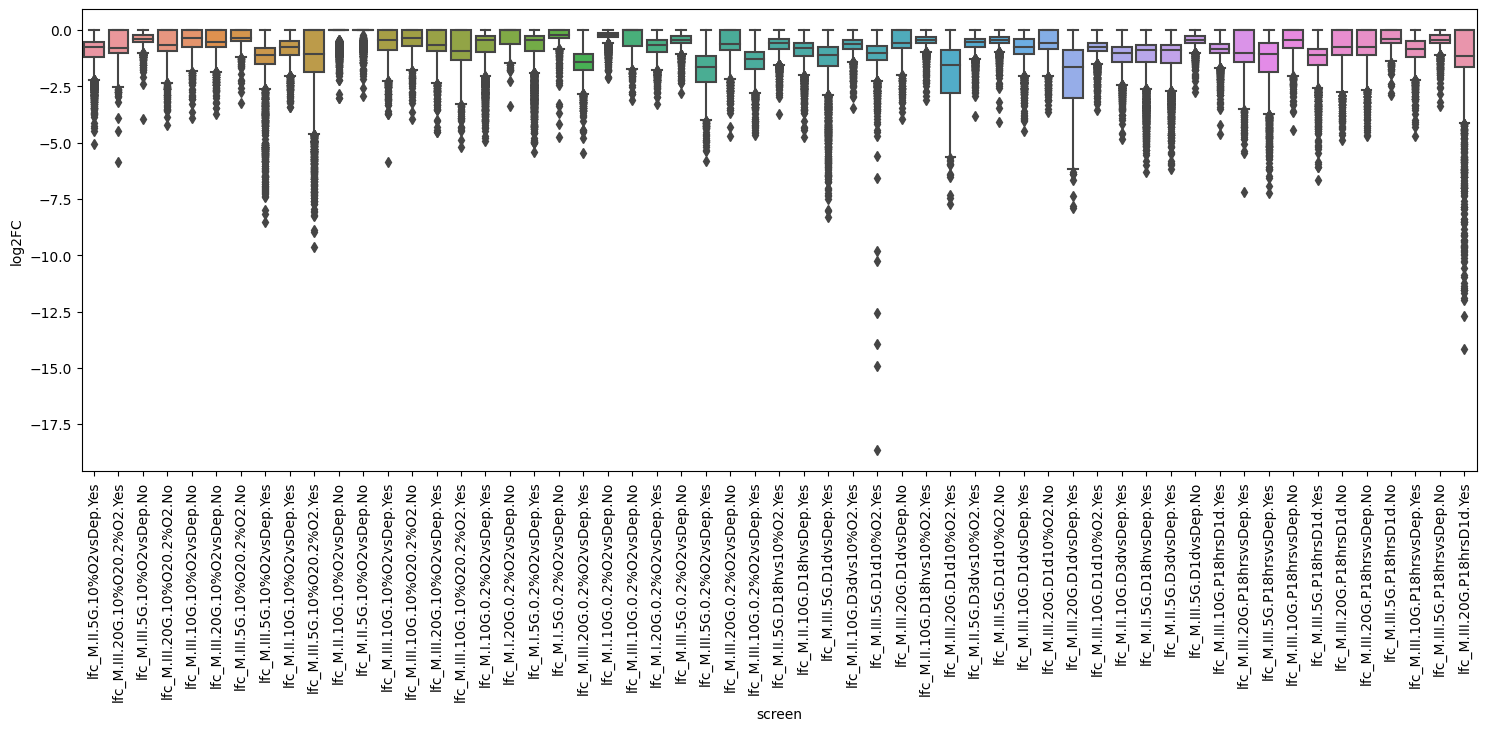

In [18]:
# Create a boxplot
plt.figure(figsize=(18, 6))  # Adjust the size as needed
sns.boxplot(x='screen', y='log2FC', data=melted_df_logFC)
xt = plt.xticks(rotation=90)  # Rotate the x labels for better readability

# [NEW]: Sort the screens by stage and sort in the variance plot above.

to explore whether there is a correlation between log2FC variance and stage.  


In [19]:
df_code_to_stage_logFC = df_meta[['Code', 'Which stage']].copy()
df_code_to_stage_logFC['screen'] = ['lfc_'+code for code in df_code_to_stage_logFC['Code']]
df_code_to_stage_logFC = df_code_to_stage_logFC[['screen', 'Which stage']].copy()
df_code_to_stage_logFC.head(2)

,screen,Which stage
0,lfc_M.I.5G.0.2%O2vsDep.No,1st
1,lfc_M.I.5G.0.2%O2vsDep.Yes,1st


In [24]:
# Merge the dataframes on the 'screen' column
merged_df_logFC = pd.merge(melted_df_logFC, df_code_to_stage_logFC, on='screen')

# Sort the merged dataframe by 'Which stage' and then by 'screen'
sorted_by_stage_df_logFC = merged_df_logFC.sort_values(by=['Which stage', 'screen'])

sorted_by_stage_df_logFC.head()

,id,screen,log2FC,Which stage
84315,RVBD3859c:gltB,lfc_M.I.10G.0.2%O2vsDep.No,-0.48452,1st
84316,RVBD3596c:clpC1,lfc_M.I.10G.0.2%O2vsDep.No,-1.07390,1st
84317,RVBD0732:secY,lfc_M.I.10G.0.2%O2vsDep.No,-1.50350,1st
84318,RVBD2524c:fas,lfc_M.I.10G.0.2%O2vsDep.No,-0.86290,1st
84319,RVBD0206c:mmpL3,lfc_M.I.10G.0.2%O2vsDep.No,-1.09800,1st


What is going on with the two screens that seem to have boxes of width zero?



In [26]:
scr1 = 'lfc_M.III.10G.D1dvsDep.No'
scr2 = 'lfc_M.III.10G.D1d10%O2.No'
sorted_by_stage_df_logFC[sorted_by_stage_df_logFC.screen.isin([scr1, scr2])].describe()

,log2FC
count,0.0
mean,NaN
std,NaN
min,NaN
25%,NaN
50%,NaN
75%,NaN
max,NaN


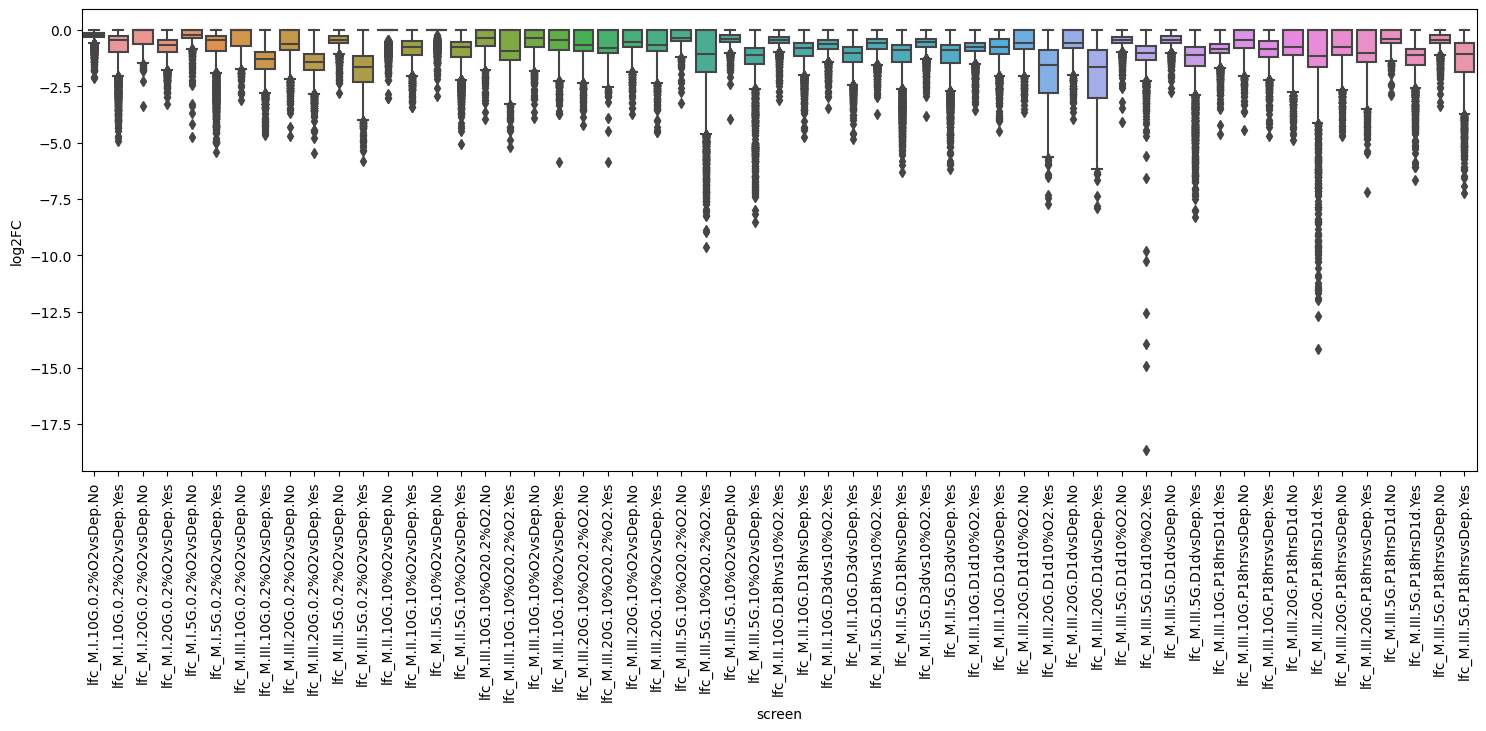

In [27]:
# Create a boxplot
plt.figure(figsize=(18, 6))  # Adjust the size as needed
sns.boxplot(x='screen', y='log2FC', data=sorted_by_stage_df_logFC)
xt = plt.xticks(rotation=90)  # Rotate the x labels for better readability

# UMAP Dimensionality Reduction and Visualization Section Overview:

This section utilizes Uniform Manifold Approximation and Projection (UMAP) to reduce the high-dimensional data of log2 fold changes (LFC) across various CRISPRi screens into a two-dimensional space.

#### In the UMAP visualization, each point represents an individual gene.
The positioning of these points is determined based on the similarity of their log2 fold change (LFC) profiles across all CRISPRi screens. Genes that exhibit similar patterns of expression changes under different experimental conditions are placed closer together in the two-dimensional space. This grouping effect allows us to visually identify clusters of genes that behave similarly across the range of experimental conditions analyzed.


The interactive scatter plot serves as an intuitive tool to explore these relationships, identify clusters or outliers, and generate hypotheses about gene behavior across different CRISPRi screens.



In [ ]:
# Drop non-numeric columns (assuming 'gene' is the column with gene names)
df_master_logFC_filled = df_master_logFC.fillna(0)
df_umap = df_master_logFC_filled.drop(columns=['id'])

# Apply UMAP
reducer = umap.UMAP(n_components=2, random_state=42)
embedding = reducer.fit_transform(df_umap)

# Store embedding coordinates in dataframe
df_umap_viz = pd.DataFrame(embedding, columns=['u1', 'u2'])
df_umap_viz['id'] = df_master_logFC['id']
df_umap_viz = df_umap_viz[['id', 'u1', 'u2']]

/usr/local/lib/python3.10/dist-packages/umap/umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


<img src='data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAAAEAAAABACAYAAACqaXHeAAAABHNCSVQICAgIfAhkiAAAAAlwSFlz
AAAB+wAAAfsBxc2miwAAABl0RVh0U29mdHdhcmUAd3d3Lmlua3NjYXBlLm9yZ5vuPBoAAA6zSURB
VHic7ZtpeFRVmsf/5966taWqUlUJ2UioBBJiIBAwCZtog9IOgjqACsogKtqirT2ttt069nQ/zDzt
tI4+CrJIREFaFgWhBXpUNhHZQoKBkIUASchWla1S+3ar7r1nPkDaCAnZKoQP/D7mnPOe9/xy76n3
nFSAW9ziFoPFNED2LLK5wcyBDObkb8ZkxuaoSYlI6ZcOKq1eWFdedqNzGHQBk9RMEwFAASkk0Xw3
ETacDNi2vtvc7L0ROdw0AjoSotQVkKSvHQz/wRO1lScGModBFbDMaNRN1A4tUBCS3lk7BWhQkgpD
lG4852/+7DWr1R3uHAZVQDsbh6ZPN7CyxUrCzJMRouusj0ipRwD2uKm0Zn5d2dFwzX1TCGhnmdGo
G62Nna+isiUqhkzuKrkQaJlPEv5mFl2fvGg2t/VnzkEV8F5ioioOEWkLG86fvbpthynjdhXYZziQ
x1hC9J2NFyi8vCTt91Fh04KGip0AaG9zuCk2wQCVyoNU3Hjezee9bq92duzzTmxsRJoy+jEZZZYo
GTKJ6SJngdJqAfRzpze0+jHreUtPc7gpBLQnIYK6BYp/uGhw9YK688eu7v95ysgshcg9qSLMo3JC
4jqLKQFBgdKDPoQ+Pltb8dUyQLpeDjeVgI6EgLIQFT5tEl3rn2losHVsexbZ3EyT9wE1uGdkIPcy
BGxn8QUq1QrA5nqW5i2tLqvrrM9NK6AdkVIvL9E9bZL/oyfMVd/jqvc8LylzRBKDJSzIExwhQzuL
QYGQj4rHfFTc8mUdu3E7yoLtbTe9gI4EqVgVkug2i5+uXGo919ixbRog+3fTbQ8qJe4ZOYNfMoTI
OoshUNosgO60AisX15aeI2PSIp5KiFLI9ubb1vV3Qb2ltwLakUCDAkWX7/nHKRmmGIl9VgYsUhJm
2NXjKYADtM1ygne9QQDIXlk49FBstMKx66D1v4+XuQr7vqTe0VcBHQlRWiOCbmmSYe2SqtL6q5rJ
zsTb7lKx3FKOYC4DoqyS/B5bvLPxvD9Qtf6saxYLQGJErmDOdOMr/zo96km1nElr8bmPOBwI9COv
HnFPRIwmkSOv9kcAS4heRsidOkpeWBgZM+UBrTFAXNYL5Vf2ii9c1trNzpYdaoVil3WIc+wdk+gQ
noie3ecCcxt9ITcLAPWt/laGEO/9U6PmzZkenTtsSMQ8uYywJVW+grCstAvCIaAdArAsIWkRDDs/
KzLm2YcjY1Lv0UdW73HabE9n6V66cxSzfEmuJssTpKGVp+0vHq73FwL46eOjpMpbRAnNmJFrGJNu
Ukf9Yrz+3rghiumCKNXXWPhLYcjxGsIpoCMsIRoFITkW8AuyM8jC1+/QLx4bozCEJIq38+1rtpR6
V/yzb8eBlRb3fo5l783N0CWolAzJHaVNzkrTzlEp2bQ2q3TC5gn6wpnoQAmwSiGh2GitnTmVMc5O
UyfKWUKCIsU7+fZDKwqdT6DDpvkzAX4/+AMFjk0tDp5GRXLpQ2MUmhgDp5gxQT8+Y7hyPsMi8uxF
71H0oebujHALECjFKaW9Lm68n18wXp2kVzIcABytD5iXFzg+WVXkegpAsOOYziqo0OkK76GyquC3
ltZAzMhhqlSNmmWTE5T6e3IN05ITFLM4GdN0vtZ3ob8Jh1NAKXFbm5PtLU/eqTSlGjkNAJjdgn/N
aedXa0tdi7+t9G0FIF49rtMSEgAs1kDLkTPO7ebm4IUWeyh1bKomXqlgMG6kJmHcSM0clYLJ8XtR
1GTnbV3F6I5wCGikAb402npp1h1s7LQUZZSMIfALFOuL3UUrfnS8+rez7v9qcold5tilgHbO1fjK
9ubb17u9oshxzMiUBKXWqJNxd+fqb0tLVs4lILFnK71H0Ind7uiPgACVcFJlrb0tV6DzxqqTIhUM
CwDf1/rrVhTa33/3pGPxJYdQ2l2cbgVcQSosdx8uqnDtbGjh9SlDVSMNWhlnilfqZk42Th2ZpLpf
xrHec5e815zrr0dfBZSwzkZfqsv+1FS1KUknUwPARVvItfKUY+cn57yP7qv07UE3p8B2uhUwLk09
e0SCOrK+hbdYHYLjRIl71wWzv9jpEoeOHhGRrJAzyEyNiJuUqX0g2sBN5kGK6y2Blp5M3lsB9Qh4
y2Ja6x6+i0ucmKgwMATwhSjdUu49tKrQ/pvN5d53ml2CGwCmJipmKjgmyuaXzNeL2a0AkQ01Th5j
2DktO3Jyk8f9vcOBQHV94OK+fPumJmvQHxJoWkaKWq9Vs+yUsbq0zGT1I4RgeH2b5wef7+c7bl8F
eKgoHVVZa8ZPEORzR6sT1BzDUAD/d9F78e2Tzv99v8D+fLVTqAKAsbGamKey1Mt9Ann4eH3gTXTz
idWtAJ8PQWOk7NzSeQn/OTHDuEikVF1R4z8BQCy+6D1aWRfY0tTGG2OM8rRoPaeIj5ZHzJxszElN
VM8K8JS5WOfv8mzRnQAKoEhmt8gyPM4lU9SmBK1MCQBnW4KONT86v1hZ1PbwSXPw4JWussVjtH9Y
NCoiL9UoH/6PSu8jFrfY2t36erQHXLIEakMi1SydmzB31h3GGXFDFNPaK8Rme9B79Ixrd0WN+1ij
NRQ/doRmuFLBkHSTOm5GruG+pFjFdAmorG4IXH1Qua6ASniclfFtDYt+oUjKipPrCQB7QBQ2lrgP
fFzm+9XWUtcqJ3/5vDLDpJ79XHZk3u8nGZ42qlj1+ydtbxysCezrydp6ugmipNJ7WBPB5tydY0jP
HaVNzs3QzeE4ZpTbI+ZbnSFPbVOw9vsfnVvqWnirPyCNGD08IlqtYkh2hjZ5dErEQzoNm+6ykyOt
Lt5/PQEuSRRKo22VkydK+vvS1XEKlhCJAnsqvcVvH7f/ZU2R67eXbMEGAMiIV5oWZWiWvz5Fv2xG
sjqNJQRvn3Rs2lji/lNP19VjAQDgD7FHhujZB9OGqYxRkZxixgRDVlqS6uEOFaJUVu0rPFzctrnF
JqijImVp8dEKVWyUXDk92zAuMZ6bFwpBU1HrOw6AdhQgUooChb0+ItMbWJitSo5Ws3IAOGEOtL53
0vHZih9sC4vtofZ7Qu6523V/fmGcds1TY3V36pUsBwAbSlxnVh2xLfAD/IAIMDf7XYIkNmXfpp2l
18rkAJAy9HKFaIr/qULkeQQKy9zf1JgDB2uaeFNGijo5QsUyacNUUTOnGO42xSnv4oOwpDi1zYkc
efUc3I5Gk6PhyTuVKaOGyLUAYPGIoY9Pu/atL/L92+4q9wbflRJ2Trpm/jPjdBtfnqB/dIThcl8A
KG7hbRuKnb8qsQsVvVlTrwQAQMUlf3kwJI24Z4JhPMtcfng5GcH49GsrxJpGvvHIaeem2ma+KSjQ
lIwUdYyCY8j4dE1KzijNnIP2llF2wcXNnsoapw9XxsgYAl6k+KzUXbi2yP3KR2ecf6z3BFsBICdW
nvnIaG3eHybqX7vbpEqUMT+9OL4Qpe8VON7dXuFd39v19FoAABRVePbGGuXTszO0P7tu6lghUonE
llRdrhArLvmKdh9u29jcFiRRkfLUxBiFNiqSU9icoZQHo5mYBI1MBgBH6wMNb+U7Pnw337H4gi1Y
ciWs+uks3Z9fztUvfzxTm9Ne8XXkvQLHNytOOZeiD4e0PgkAIAYCYknKUNUDSXEKzdWNpnil7r4p
xqkjTarZMtk/K8TQ6Qve78qqvXurGwIJqcOUKfUWHsm8KGvxSP68YudXq4pcj39X49uOK2X142O0
Tz5/u/7TVybqH0rSya6ZBwD21/gubbrgWdDgEOx9W
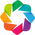

:Scatter   [u1]   (u2,id)

In [ ]:
scatter_plot = df_umap_viz.hvplot.scatter(x="u1", y="u2",
                                          hover_cols=['id'],
                                          width=1000, height=600,
                                          tools=['box_select', 'lasso_select', 'hover', 'pan', 'wheel_zoom'])

hv.extension('bokeh')
scatter_plot

[OPTIONAL]: Repeat UMAP buy by screens.

# Genes with consistently significant log2FC / p-values:

In this section, we aim to identify genes that consistently demonstrate significant changes across different experimental conditions.

For each gene, we assess the frequency with which it meets predefined thresholds for log2 fold-change and statistical significance (p-value).

The log2 fold-change threshold is used to capture genes with substantial changes in expression, while the p-value threshold ensures that these changes are statistically significant.





In [29]:
# Define thresholds
lfc_threshold = -1
pval_threshold = 0.05

# Remove the 'id' column for the comparison operations
lfc_cols_to_compare = df_master_logFC.columns[1:].str.replace('lfc_', '')  # Skip the first 'id' column
pval_cols_to_compare = df_master_pval.columns[1:].str.replace('pval_', '')  # Skip the first 'id' column

# Apply LFC threshold and p-value threshold
# Use only the columns intended for comparison
lfc_significant = (df_master_logFC.drop('id', axis=1).set_axis(lfc_cols_to_compare, axis=1, inplace=False) < lfc_threshold)
pval_significant = (df_master_pval.drop('id', axis=1).set_axis(pval_cols_to_compare, axis=1, inplace=False) < pval_threshold)

# Ensure that both dataframes are sorted by column names to align them properly
lfc_significant = lfc_significant.reindex(sorted(lfc_significant.columns), axis=1)
pval_significant = pval_significant.reindex(sorted(pval_significant.columns), axis=1)

# Combine both criteria
combined_significant = lfc_significant & pval_significant

# Count how many times each gene is significant
significant_count = combined_significant.sum(axis=1)

# Create a DataFrame with gene IDs and their corresponding significant count
df_significant_counts = pd.DataFrame({
    'id': df_master_logFC['id'],
    'significant_count': significant_count
})

# Sort the DataFrame by the significant count in descending order
df_significant_counts_sorted = df_significant_counts.sort_values(by='significant_count', ascending=False)
df_significant_counts_sorted.reset_index(drop = True, inplace = True)

fn_out = os.path.join(path_root, 'significance_counts.xlsx')
df_significant_counts_sorted.to_excel(fn_out, index = False)

# Display the DataFrame
df_significant_counts_sorted.head(20)


<ipython-input-29-3a984a177ce5>:11: FutureWarning: DataFrame.set_axis 'inplace' keyword is deprecated and will be removed in a future version. Use `obj = obj.set_axis(..., copy=False)` instead
  lfc_significant = (df_master_logFC.drop('id', axis=1).set_axis(lfc_cols_to_compare, axis=1, inplace=False) < lfc_threshold)
<ipython-input-29-3a984a177ce5>:12: FutureWarning: DataFrame.set_axis 'inplace' keyword is deprecated and will be removed in a future version. Use `obj = obj.set_axis(..., copy=False)` instead
  pval_significant = (df_master_pval.drop('id', axis=1).set_axis(pval_cols_to_compare, axis=1, inplace=False) < pval_threshold)


,id,significant_count
0,RVBD3596c:clpC1,36
1,RVBD0430:RVBD0430,34
2,RVBD1828:RVBD1828,34
3,RVBD0732:secY,32
4,RVBD0668:rpoC,32
5,RVBD2150c:ftsZ,32
6,RVBD2093c:tatC,32
7,RVBD0014c:pknB,31
8,RVBD0206c:mmpL3,31
9,RVBD0482:murB,31


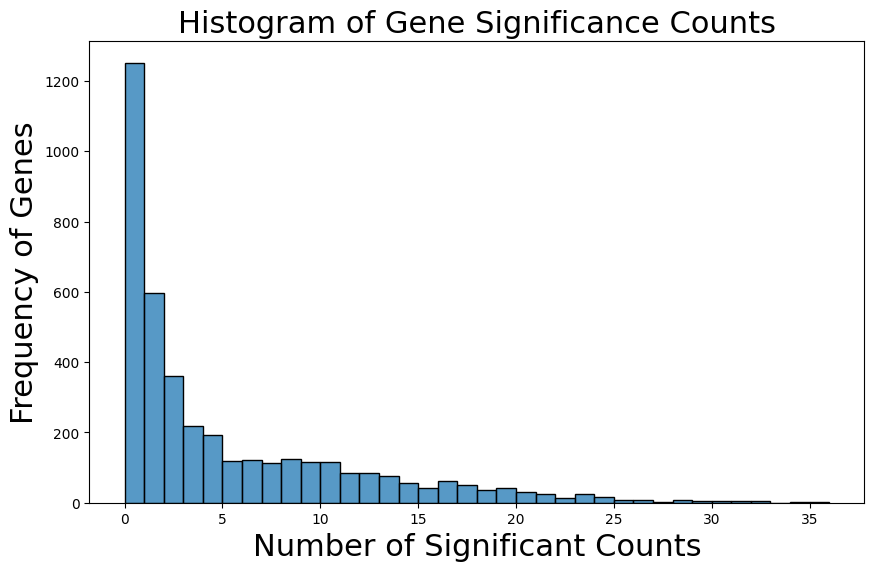

In [30]:
# Plotting the histogram of significance counts
plt.figure(figsize=(10, 6))
sns.histplot(df_significant_counts_sorted['significant_count'], bins=36, kde=False)

# Adding title and labels to the plot
plt.title('Histogram of Gene Significance Counts', fontsize = 22)
plt.xlabel('Number of Significant Counts', fontsize = 22)
yl = plt.ylabel('Frequency of Genes', fontsize = 22)

In [31]:
# Get the 'significant_count' data
data = df_significant_counts_sorted['significant_count']

# Define the number of bins you want
bins = 36

# Use numpy's histogram function to get the bin counts
counts, bin_edges = np.histogram(data, bins=bins)

# The 'counts' array contains the count of genes in each bin
print("Bin counts:", counts)

# To verify that the total counts add up to the total number of genes
print("Total genes counted:", counts.sum())
print("Total genes in DataFrame:", len(data))


Bin counts: [1252  597  360  218  192  118  121  112  125  117  115   84   84   75
   55   43   61   51   37   42   31   26   13   24   17    7    9    2
    7    4    5    4    4    0    2    1]
Total genes counted: 4015
Total genes in DataFrame: 4015


#[NEW] Total number of genes, **at each stage**, that show significance
  - Total number of genes at any stage uniquely counted. Each gene is only counted once (even if downregulated at multiple columns *within a stage* it doesn't count twice).
  - Experiment with visual companion to this analysis.

In [ ]:
# repeat melting for p-vals
melted_df_pval = df_master_pval.melt(id_vars='id', var_name='screen', value_name='pval')

,id,screen,pval
0,RVBD3859c:gltB,pval_M.II.5G.10%O2vsDep.Yes,0.000003
1,RVBD3596c:clpC1,pval_M.II.5G.10%O2vsDep.Yes,0.000003
2,RVBD0732:secY,pval_M.II.5G.10%O2vsDep.Yes,0.000003
3,RVBD2524c:fas,pval_M.II.5G.10%O2vsDep.Yes,0.000003
4,RVBD0206c:mmpL3,pval_M.II.5G.10%O2vsDep.Yes,0.000003


In [ ]:
# Add stage information to p-value melted dataframe.
df_code_to_stage_pval = df_meta[['Code', 'Which stage']].copy()
df_code_to_stage_pval['screen'] = ['pval_'+code for code in df_code_to_stage_pval['Code']]
df_code_to_stage_pval = df_code_to_stage_pval[['screen', 'Which stage']].copy()
df_code_to_stage_pval.head(2)

,screen,Which stage
0,pval_M.I.5G.0.2%O2vsDep.No,1st
1,pval_M.I.5G.0.2%O2vsDep.Yes,1st


In [ ]:
# merge with stage information:
# Merge the dataframes on the 'screen' column
merged_df_pval = pd.merge(melted_df_pval, df_code_to_stage_pval, on='screen')
# Sort the merged dataframe by 'Which stage' and then by 'screen'
sorted_by_stage_df_pval = merged_df_pval.sort_values(by=['Which stage', 'screen'])

sorted_by_stage_df_pval.head()

,id,screen,pval,Which stage
84315,RVBD3859c:gltB,pval_M.I.10G.0.2%O2vsDep.No,0.677831,1st
84316,RVBD3596c:clpC1,pval_M.I.10G.0.2%O2vsDep.No,0.000010,1st
84317,RVBD0732:secY,pval_M.I.10G.0.2%O2vsDep.No,0.000010,1st
84318,RVBD2524c:fas,pval_M.I.10G.0.2%O2vsDep.No,0.000010,1st
84319,RVBD0206c:mmpL3,pval_M.I.10G.0.2%O2vsDep.No,0.000010,1st


In [ ]:
sorted_by_stage_df_pval.shape, sorted_by_stage_df_logFC.shape

((228855, 4), (228855, 4))

In [ ]:
list_stages = sorted_by_stage_df_pval['Which stage'].unique().tolist()
list_stages

['1st', '2nd', '3rd', '4th']

In [ ]:
# Standardize screen identifiers
sorted_by_stage_df_logFC['standardized_screen'] = sorted_by_stage_df_logFC['screen'].str.replace('lfc_', '')
sorted_by_stage_df_pval['standardized_screen'] = sorted_by_stage_df_pval['screen'].str.replace('pval_', '')

# Define thresholds
lfc_threshold = -1
pval_threshold = 0.05

dict_hits_by_stage = {}

for stage in list_stages:

  # Filter for a specific stage
  df_stage_logFC = sorted_by_stage_df_logFC[sorted_by_stage_df_logFC['Which stage'] == stage].copy()
  df_stage_pval = sorted_by_stage_df_pval[sorted_by_stage_df_pval['Which stage'] == stage].copy()

  # Apply threshold filters
  df_stage_logFC_hits = df_stage_logFC[df_stage_logFC['log2FC'] <= lfc_threshold].copy()
  df_stage_pval_hits = df_stage_pval[df_stage_pval['pval'] <= pval_threshold].copy()

  # Merge the filtered dataframes on standardized screen and id
  merged_hits = pd.merge(df_stage_logFC_hits, df_stage_pval_hits, on=['standardized_screen', 'id', 'Which stage'])
  merged_hits = merged_hits[['id', 'standardized_screen', 'Which stage', 'log2FC', 'pval']]

  dict_hits_by_stage[stage] = merged_hits

In [ ]:
for stage in list_stages:
  print(stage, 'stage.\nGene (ID) and number of significant hit counts within stage:')
  val_count_df = dict_hits_by_stage[stage]['id'].value_counts()
  display(val_count_df.head(10))
  print('Total number of unique gene hits:', val_count_df.shape[0], '\n\n')


1st stage.
Gene (ID) and number of significant hit counts within stage:


RVBD1828:RVBD1828      10
RVBD0732:secY          10
RVBD0430:RVBD0430      10
RVBD0482:murB          10
RVBD3596c:clpC1         9
RVBD0006:gyrA           9
RVBD2926c:RVBD2926c     9
RVBD2229c:RVBD2229c     9
RVBD2460c:clpP2         9
RVBD2969c:RVBD2969c     9
Name: id, dtype: int64

Total number of unique gene hits: 2508 


2nd stage.
Gene (ID) and number of significant hit counts within stage:


RVBD0005:gyrB        8
RVBD0014c:pknB       8
RVBD3596c:clpC1      8
RVBD0430:RVBD0430    7
RVBD0015c:pknA       7
RVBD3336c:trpS       7
RVBD1480:RVBD1480    7
RVBD2093c:tatC       7
RVBD0716:rplE        7
RVBD0884c:serC       7
Name: id, dtype: int64

Total number of unique gene hits: 1597 


3rd stage.
Gene (ID) and number of significant hit counts within stage:


RVBD1828:RVBD1828    13
RVBD0668:rpoC        12
RVBD3043c:ctaD       12
RVBD1223:htrA        12
RVBD2150c:ftsZ       11
RVBD0903c:prrA       11
RVBD2093c:tatC       11
RVBD0058:dnaB        11
RVBD2200c:ctaC       11
RVBD3645:RVBD3645    11
Name: id, dtype: int64

Total number of unique gene hits: 1949 


4th stage.
Gene (ID) and number of significant hit counts within stage:


RVBD3596c:clpC1        8
RVBD0206c:mmpL3        8
RVBD0668:rpoC          7
RVBD2093c:tatC         7
RVBD0227c:RVBD0227c    7
RVBD0430:RVBD0430      7
RVBD0482:murB          7
RVBD0014c:pknB         7
RVBD3808c:glfT2        7
RVBD3645:RVBD3645      7
Name: id, dtype: int64

Total number of unique gene hits: 785 




In [ ]:
for stage in list_stages:
  num_sig = len(dict_hits_by_stage[stage]['id'].unique().tolist())
  print(stage, 'stage. Total number of unique significant genes at stage:', num_sig)

1st stage. Total number of unique significant genes at stage: 2508
2nd stage. Total number of unique significant genes at stage: 1597
3rd stage. Total number of unique significant genes at stage: 1949
4th stage. Total number of unique significant genes at stage: 785


# [NEW]: Proportion of these that have been labelled as essential under:
  - in "standard" lab conditions (DeJesus et al, mBio)

In [ ]:
# for standard lab conditions, we use the mBio calls.
# these essentiality calls and handily included in the MAGECK output files from Michael
# So we grab a random file and fetch it from there:
filename = 'result_1846_5Generation_PostMCFwithATc_vs_1845_5Generation_PostDepwithATc_alphamedian_control_control_lod20_10_31_2023.mageck.gene_summary.txt'
full_file_path = os.path.join(path_data, '1st_stage', filename)
df_mBio = pd.read_csv(full_file_path, sep = '\t')
df_mBio = df_mBio[['id', 'orf', 'name', 'essentiality', 'mbio Call']]
df_mBio.head()


,id,orf,name,essentiality,mbio Call
0,RVBD0006:gyrA,RVBD0006,gyrA,Essential,ES
1,RVBD1547:dnaE1,RVBD1547,dnaE1,Essential,ES
2,RVBD0005:gyrB,RVBD0005,gyrB,Essential,ES
3,RVBD2150c:ftsZ,RVBD2150c,ftsZ,Essential,ES
4,RVBD1828:RVBD1828,RVBD1828,RVBD1828,Essential,GD


In [ ]:
# stage = '1st'
for stage in list_stages:
  df_stage_ES_mBio = pd.merge(dict_hits_by_stage[stage], df_mBio, on = 'id')
  df_stage_ES_mBio_dedup = df_stage_ES_mBio.drop_duplicates(subset='id')

  print(stage, 'stage. Total unique hits:', df_stage_ES_mBio_dedup.shape[0])
  print('These genes are divided according to the following essentiality calls in DeJesus et al. mBio')
  display(df_stage_ES_mBio_dedup['mbio Call'].value_counts())
  print('\n')

1st stage. Total unique hits: 2508
These genes are divided according to the following essentiality calls in DeJesus et al. mBio


NE           1663
ES            450
GA            165
GD            116
Uncertain      32
ESD            26
Name: mbio Call, dtype: int64



2nd stage. Total unique hits: 1597
These genes are divided according to the following essentiality calls in DeJesus et al. mBio


NE           882
ES           438
GD           100
GA            76
ESD           25
Uncertain     25
Name: mbio Call, dtype: int64



3rd stage. Total unique hits: 1949
These genes are divided according to the following essentiality calls in DeJesus et al. mBio


NE           1184
ES            451
GD            111
GA             95
Uncertain      30
ESD            27
Name: mbio Call, dtype: int64



4th stage. Total unique hits: 785
These genes are divided according to the following essentiality calls in DeJesus et al. mBio


ES           368
NE           261
GD            69
ESD           21
Uncertain     17
GA            13
Name: mbio Call, dtype: int64

In [ ]:
df_stage_ES_mBio.head()

,id,standardized_screen,Which stage,log2FC,pval,orf,name,essentiality,mbio Call
0,RVBD3596c:clpC1,M.I.10G.0.2%O2vsDep.No,1st,-1.0739,0.000010,RVBD3596c,clpC1,Essential,ES
1,RVBD3596c:clpC1,M.I.10G.0.2%O2vsDep.Yes,1st,-2.3091,0.000003,RVBD3596c,clpC1,Essential,ES
2,RVBD3596c:clpC1,M.I.20G.0.2%O2vsDep.Yes,1st,-1.5552,0.000003,RVBD3596c,clpC1,Essential,ES
3,RVBD3596c:clpC1,M.I.5G.0.2%O2vsDep.No,1st,-1.6734,0.000008,RVBD3596c,clpC1,Essential,ES
4,RVBD3596c:clpC1,M.I.5G.0.2%O2vsDep.Yes,1st,-4.2957,0.000002,RVBD3596c,clpC1,Essential,ES


#[NEW] same as above, but now comparing against a mouse TnSeq screen

  - in mice (Zhang et al. 2013)

In [ ]:
path_tmp = '/content/drive/MyDrive/TheJinichLab/collaborations/Carl_Nathan/'
fn_SI = 'SI_qval_log2FC.xlsx'
path_fn = os.path.join(path_tmp, fn_SI)
df_SI = pd.read_excel(path_fn)
# 1A -- Mutants exhibiting altered fitness in mouse infection model after 10 days
# 1B -- Mutants exhibiting altered fitness in mouse infection model after 45 days
cols = ['Rv_ID', 'gene_name', '2013_Zhang_1A_q_val', '2013_Zhang_1A_log2FC', '2013_Zhang_1B_q_val', '2013_Zhang_1B_log2FC']
df_SI = df_SI[cols]
df_SI.head(2)

,Rv_ID,gene_name,2013_Zhang_1A_q_val,2013_Zhang_1A_log2FC,2013_Zhang_1B_q_val,2013_Zhang_1B_log2FC
0,Rv0001,dnaA,NaN,NaN,NaN,NaN
1,Rv0002,dnaN,NaN,NaN,NaN,NaN
2,Rv0003,recF,8.820000e-09,-6.211402,0.000087,-3.223423
3,Rv0004,-,NaN,NaN,NaN,NaN
4,Rv0005,gyrB,NaN,NaN,NaN,NaN


In [ ]:
# 45 days data
df_10d = df_SI[~df_SI['2013_Zhang_1A_log2FC'].isna()]
df_45d = df_SI[~df_SI['2013_Zhang_1B_log2FC'].isna()]

# Next steps:

- [DONE] Send list above!
- [DONE] Sort screens by stage (either K column or experimental condition string) and sort in variance plot.
- [DONE] Total number of genes, **at each stage**, that show significance
  - Total number of genes at any stage uniquely counted. Each gene is only counted once (even if downregulated at multiple columns *within a stage* it doesn't count twice).
  - Experiment with visual companion to this analysis.
- [PENDING] Proportion of these that have been labelled as essential under:
  - "standard" lab conditions
  - in mice (Sasseti et al.)
- [PENDING] Genes that are most extensively downregulated *within each stage*
- [PENDING] Repeat the analysis for enriched genes.
  - Report the number of genes enriched vs. depleted.

In [ ]:
# Define threshold
low_threshold = -1

# Count how many times each gene falls below the low threshold
low_count = (df_master_logFC.drop('id', axis=1) < low_threshold).sum(axis=1)

# Create a DataFrame with gene IDs and their corresponding low count
key_genes_low_df = pd.DataFrame({
    'id': df_master_logFC['id'],
    'low_count': low_count
})

# Sort the DataFrame based on the count, in descending order
key_genes_low_df = key_genes_low_df.sort_values(by='low_count', ascending=False)

# Display the resulting DataFrame
key_genes_low_df.head(20)



,id,low_count
814,RVBD0430:RVBD0430,48
517,RVBD0732:secY,45
2155,RVBD2150c:ftsZ,42
362,RVBD0701:rplC,42
1104,RVBD2925c:rnc,42
1474,RVBD1480:RVBD1480,42
89,RVBD0227c:RVBD0227c,41
140,RVBD3596c:clpC1,41
567,RVBD2165c:RVBD2165c,41
335,RVBD3808c:glfT2,40


In [ ]:

pval_significant

,M.II.5G.10%O2vsDep.Yes,M.III.20G.10%O20.2%O2.Yes,M.III.5G.10%O2vsDep.No,M.III.20G.10%O20.2%O2.No,M.III.10G.10%O2vsDep.No,M.III.20G.10%O2vsDep.No,M.III.5G.10%O20.2%O2.No,M.III.5G.10%O2vsDep.Yes,M.II.10G.10%O2vsDep.Yes,M.III.5G.10%O20.2%O2.Yes,...,M.III.20G.P18hrsvsDep.Yes,M.III.5G.P18hrsvsDep.Yes,M.III.10G.P18hrsvsDep.No,M.III.5G.P18hrsD1d.Yes,M.III.20G.P18hrsD1d.No,M.III.20G.P18hrsvsDep.No,M.III.5G.P18hrsD1d.No,M.III.10G.P18hrsvsDep.Yes,M.III.5G.P18hrsvsDep.No,M.III.20G.P18hrsD1d.Yes
0,True,False,False,True,True,True,False,False,True,False,...,False,False,True,False,True,True,False,True,False,False
1,True,False,True,False,True,True,False,False,True,False,...,False,True,True,True,True,True,True,True,True,False
2,True,False,True,False,True,False,False,False,True,False,...,False,True,True,True,True,False,False,True,True,False
3,True,False,False,True,True,True,False,False,True,False,...,False,False,True,True,True,True,True,True,True,False
4,True,False,True,True,True,True,False,False,True,False,...,False,True,True,True,True,True,True,True,True,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4010,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
4011,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
4012,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
4013,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,True,True,False,False,False,False


In [ ]:

# Make sure the columns are aligned before combining the criteria
# Ensure that both dataframes are sorted by column names
lfc_significant = lfc_significant.reindex(sorted(lfc_significant.columns), axis=1)
pval_significant = pval_significant.reindex(sorted(pval_significant.columns), axis=1)

# Combine both criteria
combined_significant = lfc_significant & pval_significant

# Count how many times each gene is significant
significant_count = combined_significant.sum(axis=1)

# Add the gene ids back to the significant_count series to create a DataFrame
df_significant_counts = pd.DataFrame({
    'id': df_master_logFC['id'],
    'significant_count': significant_count
})

# Sort and display the DataFrame
df_significant_counts_sorted = df_significant_counts.sort_values(by='significant_count', ascending=False)
df_significant_counts_sorted.head()


                       id  significant_count
0          RVBD3859c:gltB                  0
2681  RVBD2964B:RVBD2964B                  0
2668       RVBD2092c:helY                  0
2669       RVBD2043c:pncA                  0
2670    RVBD3074:RVBD3074                  0
...                   ...                ...
1343  RVBD3027c:RVBD3027c                  0
1344    RVBD0281:RVBD0281                  0
1345      RVBD0456A:mazF1                  0
1346       RVBD2701c:suhB                  0
4014  RVBD1576c:RVBD1576c                  0

[4015 rows x 2 columns]


# Clustering and heatmap:


In [ ]:
# Drop the specified column with many missing values
df_master_logFC.drop('lfc_M.III.10G.P18hrsD1d.No', axis=1, inplace=True)

# Impute the remaining NaNs with zeros
df_master_logFC.fillna(0, inplace=True)

# Check if there are any remaining NaNs (optional)
remaining_nans = df_master_logFC.isna().sum().sum()
print(f"Remaining NaNs: {remaining_nans}")

# Drop the specified column with many missing values
df_master_pval.drop('pval_M.III.10G.P18hrsD1d.No', axis=1, inplace=True)

# Impute the remaining NaNs with zeros
df_master_pval.fillna(1, inplace=True)

# Check if there are any remaining NaNs (optional)
remaining_nans = df_master_pval.isna().sum().sum()
print(f"Remaining NaNs: {remaining_nans}")

df_numeric = df_master_logFC.drop('id', axis=1)

np.random.seed(0)  # For reproducibility
noise = np.random.normal(0, 0.001, df_numeric.shape)  # Small Gaussian noise
df_noisy = df_numeric + noise

min_lfc = df_master_logFC.drop('id', axis=1).min().min()
max_lfc = df_master_logFC.drop('id', axis=1).max().max()
print("Min LFC:", min_lfc, "Max LFC:", max_lfc)


<Figure size 2000x2000 with 0 Axes>

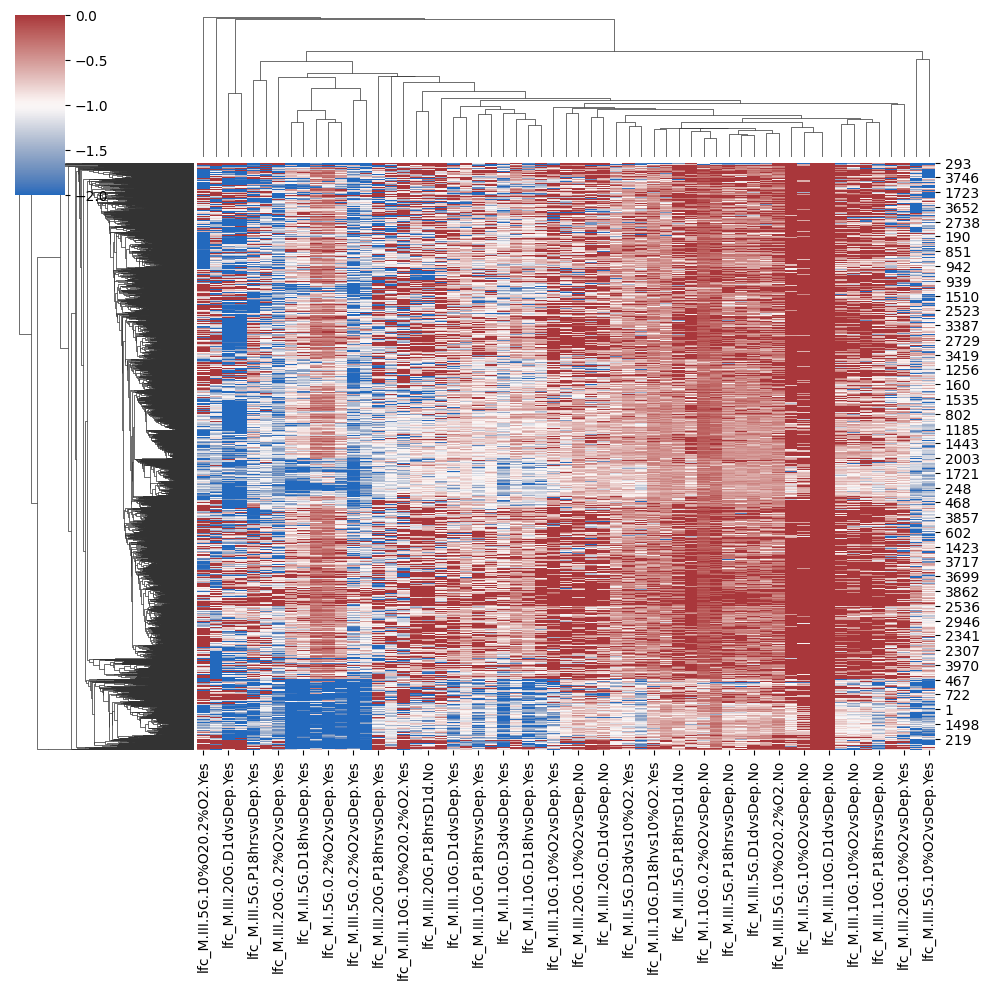

In [ ]:
# Set the figure size for the heatmap
plt.figure(figsize=(20, 20))

# Perform hierarchical clustering and create the heatmap
# Note: We will drop the 'id' column as it contains gene names and is not needed for clustering
sns.clustermap(df_noisy,
               method='average',
               metric='euclidean',
               cmap='vlag',
               vmin=-2, vmax=max_lfc)

plt.show()